# Візуалізація обробки хвоста кривої

Показує як змінюється хвіст кривої після додавання шуму

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from importlib import reload
import model_common
reload(model_common)


<module 'model_common' from '/Users/vekeryk/Projects/master-project-light/model_common.py'>

In [22]:
# Load dataset WITH noise tail processing
dataset_path = Path('datasets/dataset_1000_dl100_targeted.pkl')

# Load with noise processing
X_proc, Y_proc = model_common.load_dataset(dataset_path, crop_by_peak=True, peak_offset=0)

# Load WITHOUT noise processing (for comparison)
import pickle
with open(dataset_path, 'rb') as f:
    data = pickle.load(f)
Y_orig = torch.as_tensor(data['Y']).float()

# Apply same peak crop but NO noise
peak_indices = torch.argmax(Y_orig, dim=1)
crop_starts = peak_indices + 0  # Same as peak_offset=0

Y_no_noise = []
for i in range(len(Y_orig)):
    start = crop_starts[i].item()
    Y_no_noise.append(Y_orig[i, start:])

# Find max length
max_len = max(len(y) for y in Y_no_noise)

# Pad
Y_no_noise_padded = []
for y in Y_no_noise:
    if len(y) < max_len:
        y = torch.cat([y, torch.zeros(max_len - len(y))])
    Y_no_noise_padded.append(y)

Y_no_noise = torch.stack(Y_no_noise_padded)

print(f'With noise:    {Y_proc.shape}')
print(f'Without noise: {Y_no_noise.shape}')

✓ Cropping by peak (offset=0)
  Before crop: (1000, 701)
  After crop:  (1000, 681)
  Peak range: [20, 20]
✓ Loaded dataset from datasets/dataset_1000_dl100_targeted.pkl
  X shape: (1000, 7)  Y shape: (1000, 681)
With noise:    torch.Size([1000, 681])
Without noise: torch.Size([1000, 681])


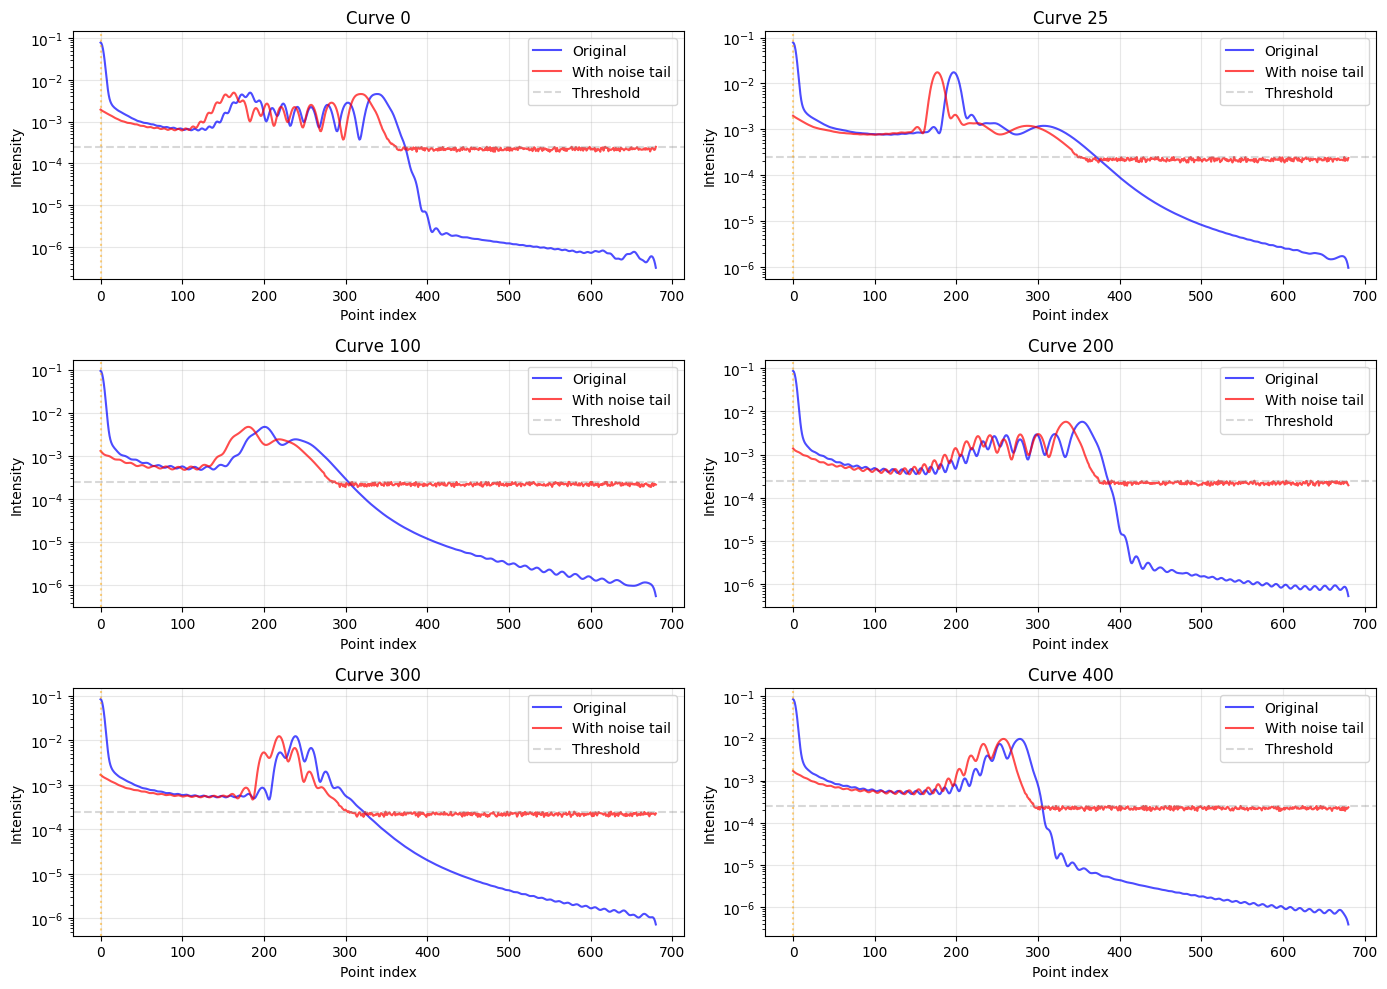

In [23]:
# Show comparison for multiple curves
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Select curves with low tails
indices = [0, 25, 100, 200, 300, 400]

for idx, (i, ax) in enumerate(zip(indices, axes.flatten())):
    curve_orig = Y_no_noise[i].numpy()
    curve_proc = Y_proc[i].numpy()
    
    # Plot both curves
    x = np.arange(len(curve_orig))
    x2 = np.arange(len(curve_proc))
    ax.semilogy(x, curve_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
    ax.semilogy(x2, curve_proc, 'r-', linewidth=1.5, alpha=0.7, label='With noise tail')

    # Mark threshold
    ax.axhline(y=0.00025, color='gray', linestyle='--', alpha=0.3, label='Threshold')
    
    # Find where noise was added
    diff = np.abs(curve_orig - curve_proc[-len(curve_orig):])
    changed_mask = diff > 1e-6
    if changed_mask.any():
        first_changed = np.where(changed_mask)[0][0]
        ax.axvline(x=first_changed, color='orange', linestyle=':', alpha=0.5)
    
    ax.set_title(f'Curve {i}')
    ax.set_xlabel('Point index')
    ax.set_ylabel('Intensity')
    ax.grid(True, alpha=0.3)
    ax.legend()
    # ax.set_ylim([1e-5, 1])

plt.tight_layout()
plt.show()

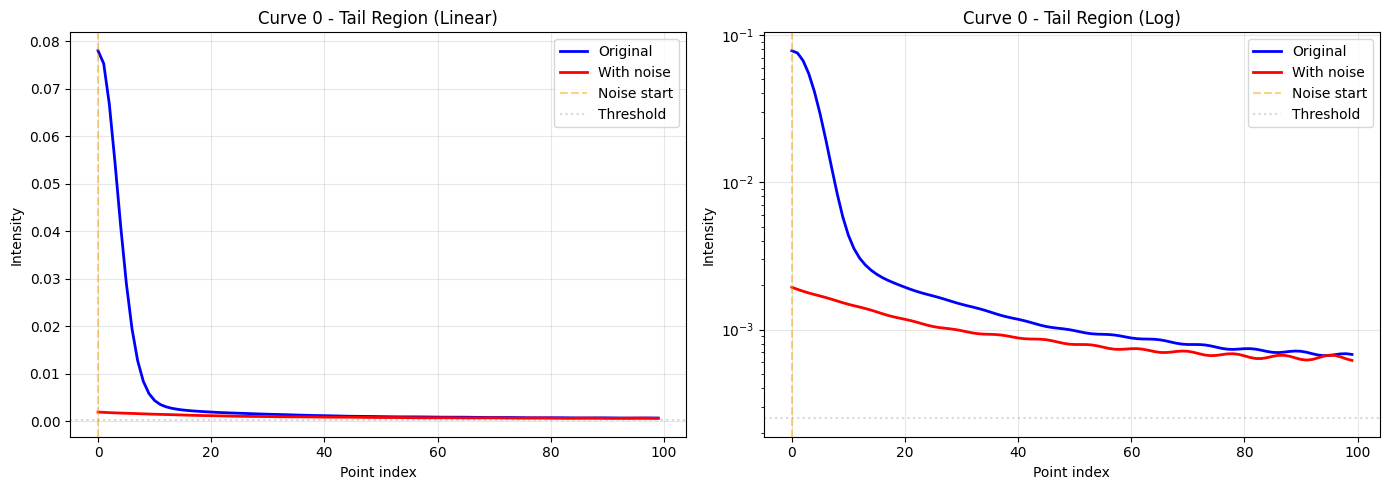


Noise region: index 0 to 681

Original tail:
  Mean: 1.499471e-03
  Std:  5.733137e-03
  Min:  3.169415e-07
  Max:  7.801850e-02

Processed tail (noise):
  Mean: 9.902528e-04
  Std:  1.103690e-03
  Min:  1.900000e-04
  Max:  4.957875e-03

Target noise: N(2.2e-4, 0.3e-4), clipped to [1.9e-4, 2.5e-4]


In [24]:
# Zoom on tail for one curve
curve_idx = 0
curve_orig = Y_no_noise[curve_idx].numpy()
curve_proc = Y_proc[curve_idx].numpy()

# Find where noise starts
diff = np.abs(curve_orig - curve_proc[-len(curve_orig):])
changed_mask = diff > 1e-6
if changed_mask.any():
    noise_start = np.where(changed_mask)[0][0]
    
    # Show region around noise start
    start_idx = max(0, noise_start - 50)
    end_idx = min(len(curve_orig), noise_start + 100)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    x = np.arange(start_idx, end_idx)
    
    # Linear scale
    axes[0].plot(x, curve_orig[start_idx:end_idx], 'b-', linewidth=2, label='Original')
    axes[0].plot(x, curve_proc[start_idx:end_idx], 'r-', linewidth=2, label='With noise')
    axes[0].axvline(x=noise_start, color='orange', linestyle='--', alpha=0.5, label='Noise start')
    axes[0].axhline(y=0.00025, color='gray', linestyle=':', alpha=0.3, label='Threshold')
    axes[0].set_title(f'Curve {curve_idx} - Tail Region (Linear)')
    axes[0].set_xlabel('Point index')
    axes[0].set_ylabel('Intensity')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Log scale
    axes[1].semilogy(x, curve_orig[start_idx:end_idx], 'b-', linewidth=2, label='Original')
    axes[1].semilogy(x, curve_proc[start_idx:end_idx], 'r-', linewidth=2, label='With noise')
    axes[1].axvline(x=noise_start, color='orange', linestyle='--', alpha=0.5, label='Noise start')
    axes[1].axhline(y=0.00025, color='gray', linestyle=':', alpha=0.3, label='Threshold')
    axes[1].set_title(f'Curve {curve_idx} - Tail Region (Log)')
    axes[1].set_xlabel('Point index')
    axes[1].set_ylabel('Intensity')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    tail_orig = curve_orig[noise_start:]
    tail_proc = curve_proc[noise_start:]
    
    print(f'\nNoise region: index {noise_start} to {len(curve_orig)}')
    print(f'\nOriginal tail:')
    print(f'  Mean: {tail_orig.mean():.6e}')
    print(f'  Std:  {tail_orig.std():.6e}')
    print(f'  Min:  {tail_orig.min():.6e}')
    print(f'  Max:  {tail_orig.max():.6e}')
    
    print(f'\nProcessed tail (noise):')
    print(f'  Mean: {tail_proc.mean():.6e}')
    print(f'  Std:  {tail_proc.std():.6e}')
    print(f'  Min:  {tail_proc.min():.6e}')
    print(f'  Max:  {tail_proc.max():.6e}')
    
    print(f'\nTarget noise: N(2.2e-4, 0.3e-4), clipped to [1.9e-4, 2.5e-4]')

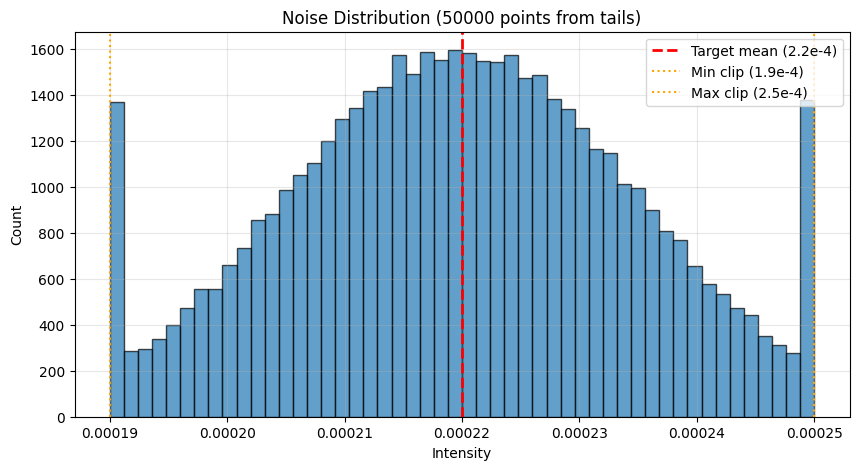

Noise stats:
  Mean: 2.200183e-04 (target: 2.2e-4)
  Std:  1.437410e-05 (target: 0.3e-4)
  Min:  1.900000e-04 (target: 1.9e-4)
  Max:  2.500000e-04 (target: 2.5e-4)


In [25]:
# Show noise distribution for all curves
all_tails = []
for i in range(len(Y_proc)):
    curve = Y_proc[i].numpy()
    # Take last 50 points as tail
    tail = curve[-50:]
    # Only keep points that look like noise (around 2e-4)
    noise_mask = (tail > 1.5e-4) & (tail < 3e-4)
    if noise_mask.any():
        all_tails.extend(tail[noise_mask])

all_tails = np.array(all_tails)

plt.figure(figsize=(10, 5))
plt.hist(all_tails, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=2.2e-4, color='r', linestyle='--', linewidth=2, label='Target mean (2.2e-4)')
plt.axvline(x=1.9e-4, color='orange', linestyle=':', label='Min clip (1.9e-4)')
plt.axvline(x=2.5e-4, color='orange', linestyle=':', label='Max clip (2.5e-4)')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title(f'Noise Distribution ({len(all_tails)} points from tails)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f'Noise stats:')
print(f'  Mean: {all_tails.mean():.6e} (target: 2.2e-4)')
print(f'  Std:  {all_tails.std():.6e} (target: 0.3e-4)')
print(f'  Min:  {all_tails.min():.6e} (target: 1.9e-4)')
print(f'  Max:  {all_tails.max():.6e} (target: 2.5e-4)')